In [245]:
%matplotlib inline
import sys, os, glob

from astropy.io import fits, ascii

import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.table import Table
import astropy.constants as const
from astropy.coordinates import SkyCoord, concatenate
from astropy import table

In [246]:
import scienceplots

plt.style.use([ 'bright', 'science', 'no-latex', 'notebook'])

In [247]:
import pyqsofit
from pyqsofit.PyQSOFit import QSOFit
print(pyqsofit.__version__)

2.0.0


In [248]:
from scipy.stats import median_abs_deviation

## Setup PyQSOFit

In [249]:
path_ex = os.path.join('.')

# create a header
hdr0 = fits.Header()
hdr0['Author'] = 'Hengxiao Guo'
primary_hdu = fits.PrimaryHDU(header=hdr0)

In [250]:
"""
In this table, we specify the priors / initial conditions and boundaries for the line fitting parameters.
"""

newdata = np.rec.array([
    (6564.61, 'Ha', 6400, 6800, 'Ha_br', 2, 0.0, 0.0, 1e10, 5e-3, 0.004, 0.05, 0.015, 0, 0, 0, 0.05, 1),
    (6564.61, 'Ha', 6400, 6800, 'Ha_na', 1, 0.0, 0.0, 1e10, 1e-3, 5e-4, 0.00169, 0.01, 1, 1, 0, 0.002, 1),
    (6549.85, 'Ha', 6400, 6800, 'NII6549', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-4, 0.00169, 5e-3, 1, 1, 1, 0.001, 1),
    (6585.28, 'Ha', 6400, 6800, 'NII6585', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-4, 0.00169, 5e-3, 1, 1, 1, 0.003, 1),
    (6718.29, 'Ha', 6400, 6800, 'SII6718', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-4, 0.00169, 5e-3, 1, 1, 2, 0.001, 1),
    (6732.67, 'Ha', 6400, 6800, 'SII6732', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-4, 0.00169, 5e-3, 1, 1, 2, 0.001, 1),

    (4862.68, 'Hb', 4640, 5100, 'Hb_br', 2, 0.0, 0.0, 1e10, 5e-3, 0.004, 0.05, 0.01, 0, 0, 0, 0.01, 1),
    (4862.68, 'Hb', 4640, 5100, 'Hb_na', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-4, 0.00169, 0.01, 1, 1, 0, 0.002, 1),
    (4960.30, 'Hb', 4640, 5100, 'OIII4959c', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-4, 0.00169, 0.01, 1, 1, 0, 0.002, 1),
    (5008.24, 'Hb', 4640, 5100, 'OIII5007c', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-4, 0.00169, 0.01, 1, 1, 0, 0.004, 1),
    (4960.30, 'Hb', 4640, 5100, 'OIII4959w',   1, 0.0, 0.0, 1e10, 3e-3, 2.3e-4, 0.004,  0.01,  2, 2, 0, 0.001, 1),
    (5008.24, 'Hb', 4640, 5100, 'OIII5007w',   1, 0.0, 0.0, 1e10, 3e-3, 2.3e-4, 0.004,  0.01,  2, 2, 0, 0.002, 1),
    #(4687.02, 'Hb', 4640, 5100, 'HeII4687_br', 1, 0.0, 0.0, 1e10, 5e-3, 0.004,  0.05,   0.005, 0, 0, 0, 0.001, 1),
    #(4687.02, 'Hb', 4640, 5100, 'HeII4687_na', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-4, 0.00169, 0.005, 1, 1, 0, 0.001, 1),

    #(3934.78, 'CaII', 3900, 3960, 'CaII3934' , 2, 0.0, 0.0, 1e10, 1e-3, 3.333e-4, 0.00169, 0.01, 99, 0, 0, -0.001, 1),

    #(3728.48, 'OII', 3650, 3800, 'OII3728', 1, 0.0, 0.0, 1e10, 1e-3, 3.333e-4, 0.00169, 0.01, 1, 1, 0, 0.001, 1),

    #(3426.84, 'NeV', 3380, 3480, 'NeV3426',    1, 0.0, 0.0, 1e10, 1e-3, 3.333e-4, 0.00169, 0.01, 0, 0, 0, 0.001, 1),
    #(3426.84, 'NeV', 3380, 3480, 'NeV3426_br', 1, 0.0, 0.0, 1e10, 5e-3, 0.0025,   0.02,   0.01, 0, 0, 0, 0.001, 1),

    (2798.75, 'MgII', 2700, 2900, 'MgII_br', 2, 0.0, 0.0, 1e10, 5e-3, 0.004, 0.05, 0.015, 0, 0, 0, 0.05, 1),
    (2798.75, 'MgII', 2700, 2900, 'MgII_na', 1, 0.0, 0.0, 1e10, 1e-3, 5e-4, 0.00169, 0.01, 1, 1, 0, 0.002, 1),

    (1908.73, 'CIII', 1700, 1970, 'CIII_br', 2, 0.0, 0.0, 1e10, 5e-3, 0.004, 0.05, 0.015, 99, 0, 0, 0.01, 1),
    #(1908.73, 'CIII', 1700, 1970, 'CIII_na',   1, 0.0, 0.0, 1e10, 1e-3, 5e-4,  0.00169, 0.01,  1, 1, 0, 0.002, 1),
    #(1892.03, 'CIII', 1700, 1970, 'SiIII1892', 1, 0.0, 0.0, 1e10, 2e-3, 0.001, 0.015,  0.003, 1, 1, 0, 0.005, 1),
    #(1857.40, 'CIII', 1700, 1970, 'AlIII1857', 1, 0.0, 0.0, 1e10, 2e-3, 0.001, 0.015,  0.003, 1, 1, 0, 0.005, 1),
    #(1816.98, 'CIII', 1700, 1970, 'SiII1816',  1, 0.0, 0.0, 1e10, 2e-3, 0.001, 0.015,  0.01,  1, 1, 0, 0.0002, 1),
    #(1786.7,  'CIII', 1700, 1970, 'FeII1787',  1, 0.0, 0.0, 1e10, 2e-3, 0.001, 0.015,  0.01,  1, 1, 0, 0.0002, 1),
    #(1750.26, 'CIII', 1700, 1970, 'NIII1750',  1, 0.0, 0.0, 1e10, 2e-3, 0.001, 0.015,  0.01,  1, 1, 0, 0.001, 1),
    #(1718.55, 'CIII', 1700, 1900, 'NIV1718',   1, 0.0, 0.0, 1e10, 2e-3, 0.001, 0.015,  0.01,  1, 1, 0, 0.001, 1),

    (1549.06, 'CIV', 1500, 1700, 'CIV_br', 2, 0.0, 0.0, 1e10, 5e-3, 0.004, 0.05, 0.015, 0, 0, 0, 0.05, 1),
    # (1549.06, 'CIV', 1500, 1700, 'CIV_na', 1, 0.0, 0.0, 1e10, 1e-3, 5e-4, 0.00169, 0.01, 1, 1, 0, 0.002, 1),
    #(1640.42, 'CIV', 1500, 1700, 'HeII1640',    1, 0.0, 0.0, 1e10, 1e-3, 5e-4,   0.00169, 0.008, 1, 1, 0, 0.002, 1),
    #(1663.48, 'CIV', 1500, 1700, 'OIII1663',    1, 0.0, 0.0, 1e10, 1e-3, 5e-4,   0.00169, 0.008, 1, 1, 0, 0.002, 1),
    #(1640.42, 'CIV', 1500, 1700, 'HeII1640_br', 1, 0.0, 0.0, 1e10, 5e-3, 0.0025, 0.02,   0.008, 1, 1, 0, 0.002, 1),
    #(1663.48, 'CIV', 1500, 1700, 'OIII1663_br', 1, 0.0, 0.0, 1e10, 5e-3, 0.0025, 0.02,   0.008, 1, 1, 0, 0.002, 1),

    #(1402.06, 'SiIV', 1290, 1450, 'SiIV_OIV1', 1, 0.0, 0.0, 1e10, 5e-3, 0.002, 0.05,  0.015, 1, 1, 0, 0.05, 1),
    #(1396.76, 'SiIV', 1290, 1450, 'SiIV_OIV2', 1, 0.0, 0.0, 1e10, 5e-3, 0.002, 0.05,  0.015, 1, 1, 0, 0.05, 1),
    #(1335.30, 'SiIV', 1290, 1450, 'CII1335',   1, 0.0, 0.0, 1e10, 2e-3, 0.001, 0.015, 0.01,  1, 1, 0, 0.001, 1),
    #(1304.35, 'SiIV', 1290, 1450, 'OI1304',    1, 0.0, 0.0, 1e10, 2e-3, 0.001, 0.015, 0.01,  1, 1, 0, 0.001, 1),

    (1215.67, 'Lya', 1150, 1290, 'Lya_br', 3, 0.0, 0.0, 1e10, 5e-3, 0.002, 0.05, 0.02, 0, 0, 0, 0.05, 1),
    (1240.14, 'Lya', 1150, 1290, 'NV1240', 1, 0.0, 0.0, 1e10, 2e-3, 0.001, 0.01, 0.005, 0, 0, 0, 0.002, 1),
    # (1215.67, 'Lya', 1150, 1290, 'Lya_na', 1, 0.0, 0.0, 1e10, 1e-3, 5e-4, 0.00169, 0.01, 0, 0, 0, 0.002, 1),
    ],

    formats='float32,    a20,  float32, float32,      a20,  int32, float32, float32, float32, float32, float32, float32, float32,   int32,  int32,  int32, float32, int32',
    names=' lambda, compname,   minwav,  maxwav, linename, ngauss,  inisca,  minsca,  maxsca,  inisig,  minsig,  maxsig,    voff,  vindex, windex, findex,  fvalue,  vary')

# Header
hdr1 = fits.Header()
hdr1['lambda'] = 'Vacuum Wavelength in Ang'
hdr1['minwav'] = 'Lower complex fitting wavelength range'
hdr1['maxwav'] = 'Upper complex fitting wavelength range'
hdr1['ngauss'] = 'Number of Gaussians for the line'

# Can be set to negative for absorption lines if you want
hdr1['inisca'] = 'Initial guess of line scale [flux]'
hdr1['minsca'] = 'Lower range of line scale [flux]'
hdr1['maxsca'] = 'Upper range of line scale [flux]'

hdr1['inisig'] = 'Initial guess of linesigma [lnlambda]'
hdr1['minsig'] = 'Lower range of line sigma [lnlambda]'
hdr1['maxsig'] = 'Upper range of line sigma [lnlambda]'

hdr1['voff  '] = 'Limits on velocity offset from the central wavelength [lnlambda]'
hdr1['vindex'] = 'Entries w/ same NONZERO vindex constrained to have same velocity'
hdr1['windex'] = 'Entries w/ same NONZERO windex constrained to have same width'
hdr1['findex'] = 'Entries w/ same NONZERO findex have constrained flux ratios'
hdr1['fvalue'] = 'Relative scale factor for entries w/ same findex'

hdr1['vary'] = 'Whether or not to vary the parameter (set to 0 to fix the line parameter to initial values)'

# Save line info
hdu1 = fits.BinTableHDU(data=newdata, header=hdr1, name='line_priors')

In [251]:
"""
In this table, we specify the windows and priors / initial conditions and boundaries for the continuum fitting parameters.
"""

conti_windows = np.rec.array([
    (1150., 1170.), 
    (1275., 1290.),
    (1350., 1360.),
    (1445., 1465.),
    (1690., 1705.),
    (1770., 1810.),
    (1970., 2400.),
    (2480., 2675.),
    (2925., 3400.),
    (3775., 3832.),
    (4000., 4050.),
    (4200., 4230.),
    (4435., 4640.),
    (5100., 5535.),
    (6005., 6035.),
    (6110., 6250.),
    (6800., 7000.),
    (7160., 7180.),
    (7500., 7800.),
    (8050., 8150.), # Continuum fitting windows (to avoid emission line, etc.)  [AA]
    ], 
    formats = 'float32,  float32',
    names =    'min,     max')

hdu2 = fits.BinTableHDU(data=conti_windows, name='conti_windows')

conti_priors = np.rec.array([
    ('Fe_uv_norm',  0.0,   0.0,   1e10,  1), # Normalization of the MgII Fe template [flux]
    ('Fe_uv_FWHM',  3000,  1200,  18000, 1), # FWHM of the MgII Fe template [AA]
    ('Fe_uv_shift', 0.0,   -0.01, 0.01,  1), # Wavelength shift of the MgII Fe template [lnlambda]
    ('Fe_op_norm',  0.0,   0.0,   1e10,  1), # Normalization of the Hbeta/Halpha Fe template [flux]
    ('Fe_op_FWHM',  3000,  1200,  18000, 1), # FWHM of the Hbeta/Halpha Fe template [AA]
    ('Fe_op_shift', 0.0,   -0.01, 0.01,  1), # Wavelength shift of the Hbeta/Halpha Fe template [lnlambda]
    ('PL_norm',     1.0,   0.0,   1e8,  1), # Normalization of the power-law (PL) continuum f_lambda = (lambda/3000)^-alpha
    ('PL_slope',    -1.5,  -5.0,  3.0,   1), # Slope of the power-law (PL) continuum
    ('Blamer_norm', 0.0,   0.0,   1e10,  1), # Normalization of the Balmer continuum at < 3646 AA [flux] (Dietrich et al. 2002)
    ('Balmer_Te',   15000, 10000, 50000, 1), # Te of the Balmer continuum at < 3646 AA [K?]
    ('Balmer_Tau',  0.5,   0.1,   2.0,   1), # Tau of the Balmer continuum at < 3646 AA
    ('conti_a_0',  0, -1e10, 1e2,  1), # 1st coefficient of the polynomial continuum
    ('conti_a_1',  0, -1e10, 1e2,  1), # 2nd coefficient of the polynomial continuum
    ('conti_a_2',  0, -1e10, 1e2,  1), # 3rd coefficient of the polynomial continuum
    # TODO: In a future version, we may add options to add more if you want...
    # ('conti_pl_3',  0.0,  -1e10,  1e10,  1), # 4th coefficient of the polynomial continuum
    # ('conti_pl_4',  0.0,  -1e10,  1e10,  1), # 5th coefficient of the polynomial continuum
    ],

    formats = 'a20,  float32, float32, float32, int32',
    names = 'parname, initial,   min,     max,     vary')

hdr3 = fits.Header()
hdr3['ini'] = 'Initial guess of line scale [flux]'
hdr3['min'] = 'FWHM of the MgII Fe template'
hdr3['max'] = 'Wavelength shift of the MgII Fe template'

hdr3['vary'] = 'Whether or not to vary the parameter (set to 0 to fix the continuum parameter to initial values)'


hdu3 = fits.BinTableHDU(data=conti_priors, header=hdr3, name='conti_priors')

In [252]:
"""
In this table, we allow user to customized some key parameters in our result measurements.
"""

measure_info = Table(
    [
        [[1350, 1450, 3000, 4200, 5100]],
        [[
            # [2240, 2650], 
            [4435, 4685],
        ]]
    ],
    names=([
        'cont_loc',
        'Fe_flux_range'
    ]),
    dtype=([
        'float32',
        'float32'
    ])
)
hdr4 = fits.Header()
hdr4['cont_loc'] = 'The wavelength of continuum luminosity in results'
hdr4['Fe_flux_range'] = 'Fe emission wavelength range calculated in results'

hdu4 = fits.BinTableHDU(data=measure_info, header=hdr4, name='measure_info')

hdu_list = fits.HDUList([primary_hdu, hdu1, hdu2, hdu3, hdu4])
hdu_list.writeto(os.path.join(path_ex, 'qsopar.fits'), overwrite=True)

In [253]:
path_ex

'.'

## Fit the spectra

In [254]:
data_agn_updated = ascii.read('hsc_agn_updated.txt')

ra, dec = data_agn_updated['RAdeg'], data_agn_updated['DEdeg']
data_coords = SkyCoord(ra, dec, unit=[u.deg, u.deg])

In [268]:
data_agn_BH = Table(np.array([-1]), names=['ID']) # dummy row

data_agn_BH['L5100'] = -1.
data_agn_BH['L3000'] = -1.
data_agn_BH['L1350'] = -1.

data_agn_BH['Lconti'] = -1.

data_agn_BH['M_Hb'] = -1.
data_agn_BH['M_MgII'] = -1.
data_agn_BH['M_CIV'] = -1.

data_agn_BH['M_Hb_line'] = -1.
data_agn_BH['M_MgII_line'] = -1.
data_agn_BH['M_CIV_line'] = -1.

data_agn_BH['M_Hb_e'] = -1.
data_agn_BH['M_MgII_e'] = -1.
data_agn_BH['M_CIV_e'] = -1.

data_agn_BH['M_Hb_line_e'] = -1.
data_agn_BH['M_MgII_line_e'] = -1.
data_agn_BH['M_CIV_line_e'] = -1.

data_agn_BH

ID,L5100,L3000,L1350,Lconti,M_Hb,M_MgII,M_CIV,M_Hb_line,M_MgII_line,M_CIV_line,M_Hb_e,M_MgII_e,M_CIV_e,M_Hb_line_e,M_MgII_line_e,M_CIV_line_e
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
-1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


Pipeline to loop through each source, get the spectrum (if there is one), and fit it.

In [269]:
def calc_M_BH_vir(logL, FWHM_line, FWHM_res=69, line_name='Ha', method='conti'):
    """
    Calculate the single-epoch (virial) black hole mass from the
    continuum luminosity and broad line FWHM
    
    Parameter:
    ----------
    logL: float
        log10 of the continuum or broad-line line luminosity in erg / s
        
    FWHM: float
        broad line FWHM in km / s

    line_name: str

    method: str
    
    Return:
    -----------
    Computed black hole mass M_BH,vir in Solar masses    
    
    "This approach assumes that the broad-line region (BLR)
    is virialized, the continuum luminosity is used as a proxy
    for the BLR radius, and the broad line width (FWHM) is used
    as a proxy for the virial velocity." -- Shen et al. (2011)
    """
    
    key = line_name.split('_')[0] # Remove the _br

    if method == 'conti':
        
        #    VP06           S11            VP06
        a = {'Hb': 0.910 , 'MgII': 0.740, 'CIV':0.660}
        b = {'Hb': 0.50,   'MgII': 0.62,  'CIV':0.53}

    elif method == 'line':

        a = {'Hb': 1.63 , 'MgII': 1.70, 'CIV':1.52}
        b = {'Hb': 0.49,  'MgII': 0.63, 'CIV':0.46}
    
    # Subtract component from instrumental broadening
    FWHM = np.sqrt(FWHM_line**2 - FWHM_res**2)
    
    return a[key] + b[key]*(logL-44) + 2*np.log10(FWHM)

In [298]:
def measureMBH(ID, src, z, wave, flux, flux_err):
    fill = np.full(len(data_agn_BH.colnames)-1, -1.0)
    # Add a row to the table
    data_agn_BH.add_row(np.concatenate(([ID], fill)))

    name = src+', ID = '+str(ID)
    
    # Prepare data
    try:
        q_noFeII = QSOFit(wave, flux, flux_err, z, path=path_ex)
        q_noFeII.Fit(name=name, nsmooth=1, deredden=True, reject_badpix=True,  #wave_range= np.array([1000, 11000]), \
              wave_mask=None, decompose_host=True, BC03=True, BC=False, npca_gal=8, npca_qso=5, \
              Fe_uv_op=False, poly=True, rej_abs_conti=True, rej_abs_line=True, MC=False, nsamp=200, linefit=True, \
              plot_fig=False, save_result=False, kwargs_plot={'save_fig_path': '.', 'plot_br_prop':True},
              save_fits_name=None, verbose=False, save_fig=False)
    except:
        plt.plot(wave, flux)
        plt.plot(wave, flux_err)
        return
    
    ## IF the chi2 is really bad > 10, remove Fe II and try again
    q_FeII = QSOFit(wave, flux, flux_err, z, path=path_ex)
    q_FeII.Fit(name=name, nsmooth=1, deredden=True, reject_badpix=True,  #wave_range= np.array([1000, 11000]), \
              wave_mask=None, decompose_host=True, BC03=True, BC=False, npca_gal=8, npca_qso=5, \
              Fe_uv_op=True, poly=True, rej_abs_conti=True, rej_abs_line=True, MC=False, nsamp=200, linefit=True, \
              plot_fig=False, save_result=False, kwargs_plot={'save_fig_path': '.', 'plot_br_prop':True},
              save_fits_name=None, verbose=False, save_fig=False)

    # Use Fe II it if chi2 improves by ~20%
    if (q_noFeII.conti_fit.redchi - q_FeII.conti_fit.redchi)/q_FeII.conti_fit.redchi > 0.2:
        q = q_FeII
        print('use Fe ii')
    else:
        q = q_noFeII

    # TODO: consider error 
    Lconti = -1
    L5100 = float(q.conti_result[q.conti_result_name=='L5100'][0])
    L3000 = float(q.conti_result[q.conti_result_name=='L3000'][0])
    L1350 = float(q.conti_result[q.conti_result_name=='L1350'][0])

    # err:
    
    if L1350 > 0:
        Lconti = L1350
        data_agn_BH['L1350'][:-1] = L1350
    if L3000 > 0:
        Lconti = L3000
        data_agn_BH['L3000'][:-1] = L3000
    if L5100 > 0:
        Lconti = L5100
        data_agn_BH['L5100'][:-1] = L5100

    data_agn_BH['Lconti'][:-1] = Lconti

    M_BH_Hbs = []
    M_BH_MgIIs = []
    M_BH_CIVs = []

    M_BH_Hbs_line = []
    M_BH_MgIIs_line = []
    M_BH_CIVs_line = []

    print('Lconti', Lconti)
    
    for j in range(1):
        line_name = 'Hb_br'
        fwhm, sigma, ew, peak, area, snr = q.line_prop_from_name(line_name, line_type='broad') #, sample_index=i)
        print('Hb', fwhm)
        if snr > 2:
            M_BH_Hbs.append(calc_M_BH_vir(Lconti, fwhm, line_name=line_name))
            M_BH_Hbs_line.append(calc_M_BH_vir(np.log10(q.flux2L(area)), fwhm, line_name=line_name, method='line'))

        line_name = 'MgII_br'
        fwhm, sigma, ew, peak, area, snr = q.line_prop_from_name(line_name, line_type='broad') #, sample_index=i)
        print('MgII', fwhm)
        if snr > 2:
            M_BH_MgIIs.append(calc_M_BH_vir(Lconti, fwhm, line_name=line_name))
            M_BH_MgIIs_line.append(calc_M_BH_vir(np.log10(q.flux2L(area)), fwhm, line_name=line_name, method='line'))

        line_name = 'CIV_br'
        fwhm, sigma, ew, peak, area, snr = q.line_prop_from_name(line_name, line_type='broad') #, sample_index=i)
        print('CIV', fwhm)
        if snr > 2:
            M_BH_CIVs.append(calc_M_BH_vir(Lconti, fwhm, line_name=line_name))
            M_BH_CIVs_line.append(calc_M_BH_vir(np.log10(q.flux2L(area)), fwhm, line_name=line_name, method='line'))
        

    # Line calculations
    data_agn_BH['M_Hb'][:-1] = np.median(M_BH_Hbs)
    data_agn_BH['M_MgII'][:-1] = np.median(M_BH_MgIIs)
    data_agn_BH['M_CIV'][:-1] = np.median(M_BH_CIVs)

    data_agn_BH['M_Hb_line'][:-1] = np.median(M_BH_Hbs_line)
    data_agn_BH['M_MgII_line'][:-1] = np.median(M_BH_MgIIs_line)
    data_agn_BH['M_CIV_line'][:-1] = np.median(M_BH_CIVs_line)

    data_agn_BH['M_Hb_e'][:-1] = np.std(M_BH_Hbs)
    data_agn_BH['M_MgII_e'][:-1] = np.std(M_BH_MgIIs)
    data_agn_BH['M_CIV_e'][:-1] = np.std(M_BH_CIVs)

    data_agn_BH['M_Hb_line_e'][:-1] = np.std(M_BH_Hbs_line)
    data_agn_BH['M_MgII_line_e'][:-1] = np.std(M_BH_MgIIs_line)
    data_agn_BH['M_CIV_line_e'][:-1] = np.std(M_BH_CIVs_line)

    #### Save the figures here
    
    plt.show()
    return


In [ ]:
line_cen = np.array( [6564.60,            4862.68,    2797,    1908, 1549.06, 1215.67])
line_name = np.array([r'H$\alpha$+[NII]', r'H$\beta$','MgII'  , 'CIII]', 'CIV',   r'Ly$\alpha$'])

wmin = 4000
wmax = 11000

#for i,ID in enumerate(data_agn_download['ID'][z_count>1]): 
for i,ID in enumerate(data_agn_updated['ID']):

    print('ID::', ID) # Empty or corrupt fits file
    if ID == 439: 
        continue
    
    ra = data_agn_updated['RAdeg'][i]
    dec = data_agn_updated['DEdeg'][i]

    z = data_agn_updated['z'][i]

    src = ''

    ## TODO:: handle multiple spectra sources..
    
    # zCOSMOS
    if os.path.isfile('spec/zCOSMOS/zcosmos_%d.fits'%ID): 

        src = 'zCOSMOS'
        
        hdu0 = fits.open('spec/zCOSMOS/zcosmos_%d.fits'%ID)
        data0 = hdu0[1].data
        wave = data0['WAVE'][0]
        flux = data0['FLUX_REDUCED'][0]/1e-17
        flux_err = np.full_like(flux, median_abs_deviation(flux, scale='normal', nan_policy='omit'))

        # DO THE FITTING
        measureMBH(ID, src, z, wave, flux, flux_err)
            
    # Magellan
    if os.path.isfile('spec/Magellan/magellan_%d.fits'%ID): 

        src = 'Magellan'
        
        hdu1 = fits.open('spec/Magellan/magellan_%d.fits'%ID)
        data1 = hdu1[0].data
        wave = data1[0]
        flux = data1[1]/1e-17
        flux_err = data1[2]/1e-17

        # DO THE FITTING
        measureMBH(ID, src, z, wave, flux, flux_err)

    # DEIMOS
    if os.path.isfile('spec/DEIMOS/deimos_%d.fits'%ID): 

        src = 'DEIMOS'
        
        hdu3 = fits.open('spec/DEIMOS/deimos_%d.fits'%ID)
        
        data3 = hdu3[1].data
        if 'FLUX' not in data3.names:
            continue
        
        wave = data3['LAMBDA'][0]
        flux = data3['FLUX'][0]*1e-19/1e-17
        flux_err = np.full_like(flux, median_abs_deviation(flux, scale='normal', nan_policy='omit'))

        # DO THE FITTING
        measureMBH(ID, src, z, wave, flux, flux_err)
                
    # SDSS
    if os.path.isfile('spec/SDSS/sdss_%d.fits'%ID): 
        
        src = 'SDSS'
        
        hdu = fits.open('spec/SDSS/sdss_%d.fits'%ID)
        mask = np.isfinite(hdu[1].data['flux'])
        wave = 10**hdu[1].data['loglam'][mask]
        flux = hdu[1].data['flux'][mask]
        flux_err = 1/np.sqrt(hdu[1].data['ivar'][mask])

        # DO THE FITTING
        measureMBH(ID, src, z, wave, flux, flux_err)

    # DESI
    if os.path.isfile('spec/desi/desi_%d.txt'%ID):

        src = 'DESI'
        
        data_spec = ascii.read('spec/desi/desi_%d.txt'%ID)

        wave = data_spec['col1']
        flux = data_spec['col2']
        flux_err = 1/np.sqrt(data_spec['col3'])

        # DO THE FITTING
        measureMBH(ID, src, z, wave, flux, flux_err)

    # 3D-HST
    """
    if os.path.isfile('spec/3D HST/3dhst_%d.fits'%ID): 

        z_3dhst = data_agn_download['z_3dhst'][ID-1]
        
        hdu = fits.open('spec/3D HST/3dhst_%d.fits'%ID)
        flux_3dhst = hdu[1].data['flux']*hdu[1].data['sensitivity']
        ax.plot(hdu[1].data['wave'], flux_3dhst,
                 label=f'3D-HST (z={z_3dhst})', color='b', linewidth=1);
        
        mask = np.isfinite(flux_3dhst)
        ylim = np.max([ylim, np.nanmax(flux_3dhst[mask])])
    """  

    # FMOS
    def fmos(filename):
        hdu0 = fits.open(filename)
        flux_fmos = hdu0[0].data
        flux_fmos_err = np.full_like(flux_fmos, median_abs_deviation(flux_fmos, scale='normal', nan_policy='omit'))
        x_start = hdu0[0].header['CRVAL1'] # 15600
        x_stop = hdu0[0].header['CRVAL1'] + hdu0[0].header['NAXIS1']*hdu0[0].header['CD1_1'] # 15600+1920*1.25
        x_step = hdu0[0].header['CD1_1'] # 1.25
        wave = np.arange(x_start, x_stop, x_step)
        return wave, flux_fmos, flux_fmos_err

    # NOTE: FMOS are NIR spectra, not optical
    # # FMOS hl
    if os.path.isfile('spec/FMOS/fmos_%d_hl.fits'%ID): 
        wave, flux, flux_err = fmos('spec/FMOS/fmos_%d_hl.fits'%ID)

        # DO THE FITTING
        measureMBH(ID, src, z, wave, flux, flux_err)

    # # FMOS jl
    if os.path.isfile('spec/FMOS/fmos_%d_jl.fits'%ID): 
        wave, flux, flux_err = fmos('spec/FMOS/fmos_%d_hl.fits'%ID)

        # DO THE FITTING
        measureMBH(ID, src, z, wave, flux, flux_err)

    # LEGA-C
    for legac_mask in list(range(1, 33))+list(range(101, 103)): 
        if os.path.isfile('spec/LEGA-C/legac_%d_M%d.fits'%(ID, legac_mask)):
            hdu0 = fits.open('spec/LEGA-C/legac_%d_M%d.fits'%(ID, legac_mask))
            wave =  hdu0[1].data['WAVE'][0]
            flux = hdu0[1].data['FLUX'][0]*1e-2
            flux_err = hdu0[1].data['ERR'][0]*1e-2

            # DO THE FITTING
            measureMBH(ID, src, z, wave, flux, flux_err)


ID:: 1
ID:: 2
debug:
[1222.65045908 1223.21751426 1223.78446099 ... 2151.97278378 2152.53994741
 2153.10689414] [0.78377154 0.11910443 0.03715898 ... 0.58812177 0.72561402 0.43098119] [0.19746885 0.19746885 0.19746885 ... 0.19746885 0.19746885 0.19746885]
debug:
[1222.65045908 1223.21751426 1223.78446099 ... 2151.97278378 2152.53994741
 2153.10689414] [0.78377154 0.11910443 0.03715898 ... 0.58812177 0.72561402 0.43098119] [0.19746885 0.19746885 0.19746885 ... 0.19746885 0.19746885 0.19746885]
Lconti 44.785420329303626
Hb 0 44.785420329303626
MgII 0 44.785420329303626
CIV 8761.154391309557 44.785420329303626
debug:
[ 789.83569693  790.56319543  790.74549028 ... 2290.53378534 2291.06212591
 2291.58786382] [ 65.84123275   8.94895539  11.18490054 ...  30.61555962 -11.76743721
 -10.29401072] [15.90958479 15.38813369 14.40768792 ... 15.01285941 25.2151865
 24.99944879]
debug:
[ 789.83569693  790.56319543  790.74549028 ... 2290.53378534 2291.06212591
 2291.58786382] [ 65.84123275   8.94895539

In [196]:
### TODO: Check, e.g. Mg II narrow/broad line, excl. ultra-broad components from BH mass

In [211]:
data_join[(data_join['ID'] == 87)]

ID,RAdeg,DEdeg,i-mag,X-flag,g-flag,r-flag,i-flag,z-flag,n-corr,ID-COSMOS2015,z,z_phot,z0,z1,z2,z3,z4,z5,r_z,r_z0,r_z1,r_z4,fagn,logMs,logMs_e,SFR,SFR_e,dchi2,chi2,L5100,L3000,L1350,M_Hb,M_MgII,M_CIV,M_Hb_line,M_MgII_line,M_CIV_line,M_Hb_e,M_MgII_e,M_CIV_e,M_Hb_line_e,M_MgII_line_e,M_CIV_line_e
int64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
87,150.49565,2.41256,21.62,1,1,1,1,1,6,734723,0.9792782,-1.0,-1.0,0.9792782,-1.0,-1.0,1.369,-1.0,1,-1,7,1,0.0,-inf,nan,-inf,-inf,0.0,-0.0,-1.0,44.15365601380513,-1.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [197]:
data_agn_BH[(data_agn_BH['Lconti'] < 43) & (data_agn_BH['Lconti'] > 0)]

ID,L5100,L3000,L1350,Lconti,M_Hb,M_MgII,M_CIV,M_Hb_line,M_MgII_line,M_CIV_line,M_Hb_e,M_MgII_e,M_CIV_e,M_Hb_line_e,M_MgII_line_e,M_CIV_line_e
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
22,-1.0,42.14169460228151,-1.0,42.14169460228151,nan,7.4005362928647624,nan,nan,9.111666227959404,nan,nan,0.0,nan,nan,0.0,nan
57,-1.0,42.86875952072449,-1.0,42.86875952072449,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
159,42.947136049750604,-1.0,-1.0,42.947136049750604,9.468840977085693,nan,nan,9.984320946197517,nan,nan,0.0,nan,nan,0.0,nan,nan
167,42.83184596968479,-1.0,-1.0,42.83184596968479,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
180,42.26452518912561,-1.0,-1.0,42.26452518912561,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
189,42.291674186106405,42.522675260944574,-1.0,42.291674186106405,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
190,42.36021228008513,-1.0,-1.0,42.36021228008513,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
197,42.99905125991969,43.10836385801502,-1.0,42.99905125991969,nan,8.197069594327573,nan,nan,8.147435148066426,nan,nan,0.0,nan,nan,0.0,nan
205,41.38619929414596,-1.0,-1.0,41.38619929414596,6.944062792169777,nan,nan,7.505087557098528,nan,nan,0.0,nan,nan,0.0,nan,nan


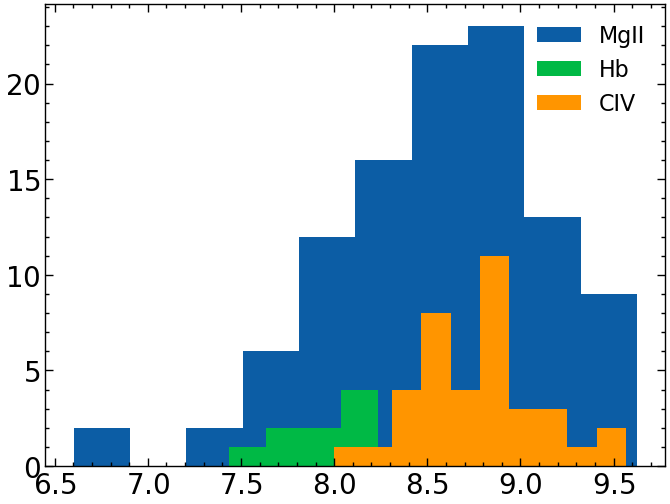

In [212]:
plt.hist(data_agn_BH['M_MgII'][data_agn_BH['M_MgII']>0], label='MgII')
plt.hist(data_agn_BH['M_Hb'][data_agn_BH['M_Hb']>0], label='Hb')
plt.hist(data_agn_BH['M_CIV'][data_agn_BH['M_CIV']>0], label='CIV')
plt.legend()

Text(15.95775227864583, 0.5, 'Number')

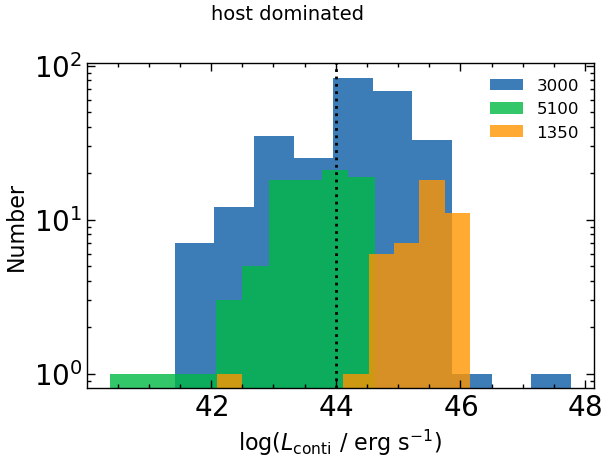

In [213]:
fig, ax = plt.subplots(1,1, figsize=(6, 4.5))

ax.hist(data_agn_BH['L3000'][data_agn_BH['L3000']>0], label='3000', alpha=0.8, log=True)
ax.hist(data_agn_BH['L5100'][data_agn_BH['L5100']>0], label='5100', alpha=0.8)
ax.hist(data_agn_BH['L1350'][data_agn_BH['L1350']>0], label='1350', alpha=0.8)
ax.legend(fontsize=12)

ax.axvline(44, color='k', linestyle='dotted')

ax.text(42, 2e2, 'host dominated', fontsize=14)


fig.tight_layout()
ax.set_xlabel(r'$\log(L_{\rm{conti}}\ /\ $erg s$^{-1}$)')
ax.set_ylabel('Number')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


TypeError: Axes.scatter() missing 2 required positional arguments: 'x' and 'y'

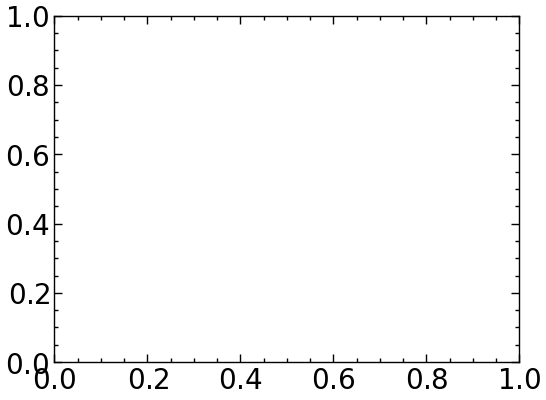

In [214]:
fig, ax = plt.subplots(1,1, figsize=(6, 4.5))


# L conti vs. d BH mass

ax.legend(fontsize=12)

ax.scatter()

ax.axvline(44, color='k', linestyle='dotted')

ax.text(42, 2e2, 'host dominated', fontsize=14)


fig.tight_layout()
ax.set_xlabel(r'$\log(L_{\rm{conti}}\ /\ $erg s$^{-1}$)')
ax.set_ylabel('Number')


In [215]:
data_sed.columns

<TableColumns names=('ID','fagn','logMs','logMs_e','SFR','SFR_e','dchi2','chi2')>

In [ ]:
data_sed

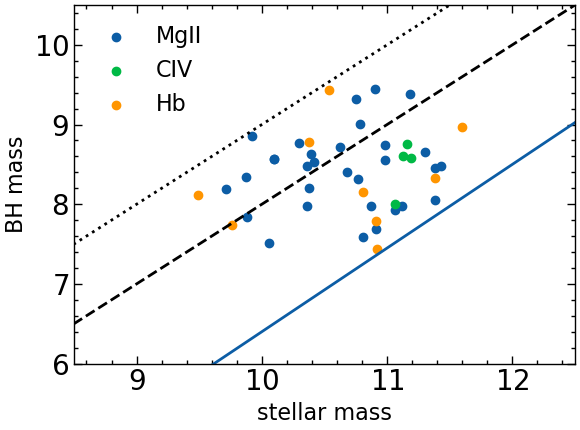

In [216]:
data_sed = ascii.read('table_mass.dat')
data_join = table.join(data_sed, data_agn_BH, keys='ID')
data_join = table.join(data_agn_updated, data_join, keys='ID')
mask_chi2 = (data_join['dchi2'] > 3) & (data_join['chi2']<10) # This selects against very luminous AGNs / high BHs or non SF galaxies

# TODO: Line SNR > 2

fig, ax = plt.subplots(1,1, figsize=(6, 4.5))

#
x = np.logspace(8, 13)
ax.plot(np.log10(x), 7.45 + 1.05*np.log10(x/1e11))

ax.plot(np.log10(x), np.log10(x/10) , linestyle='dotted', color='k')
ax.plot(np.log10(x), np.log10(x/100), linestyle='dashed', color='k')

ax.scatter(data_join['logMs'][mask_chi2], data_join['M_MgII'][mask_chi2], label='MgII')
ax.scatter(data_join['logMs'][mask_chi2], data_join['M_CIV'][mask_chi2], label='CIV')
ax.scatter(data_join['logMs'][mask_chi2], data_join['M_Hb'][mask_chi2], label='Hb')
ax.legend()
ax.set_xlim(8.5, 12.5)
ax.set_ylim(6, 10.5)

ax.set_xlabel('stellar mass')
ax.set_ylabel('BH mass')

fig.tight_layout()

# Color by redshift
# Check with Jennifers paper
# Seems consistent with Fabio's result https://arxiv.org/pdf/2308.12331.pdf

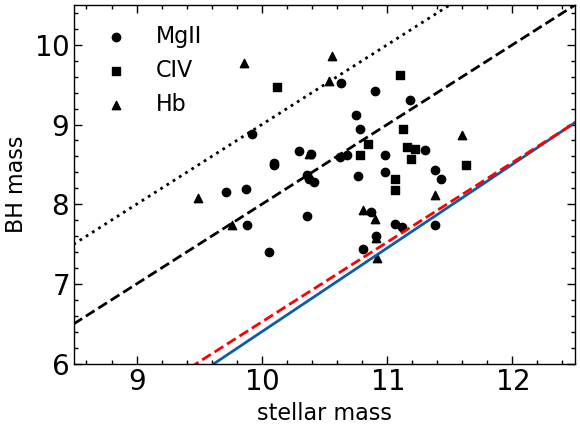

In [223]:
# TODO: Line SNR > 2

fig, ax = plt.subplots(1,1, figsize=(6, 4.5))

#
x = np.logspace(8, 13)
ax.plot(np.log10(x), 7.45 + 1.05*np.log10(x/1e11))

ax.plot(np.log10(x), np.log10(x/10) , linestyle='dotted', color='k')
ax.plot(np.log10(x), np.log10(x/100), linestyle='dashed', color='k')

ax.plot(np.log10(x), np.log10(x/3000), linestyle='dashed', color='r')


ax.scatter(data_join['logMs'][mask_chi2], data_join['M_MgII_line'][mask_chi2], label='MgII', marker='o', color='k')
ax.scatter(data_join['logMs'][mask_chi2], data_join['M_CIV_line'][mask_chi2], label='CIV', marker='s', color='k')
ax.scatter(data_join['logMs'][mask_chi2], data_join['M_Hb_line'][mask_chi2], label='Hb', marker='^', color='k')


ax.legend()
ax.set_xlim(8.5, 12.5)
ax.set_ylim(6, 10.5)

ax.set_xlabel('stellar mass')
ax.set_ylabel('BH mass')

fig.tight_layout()


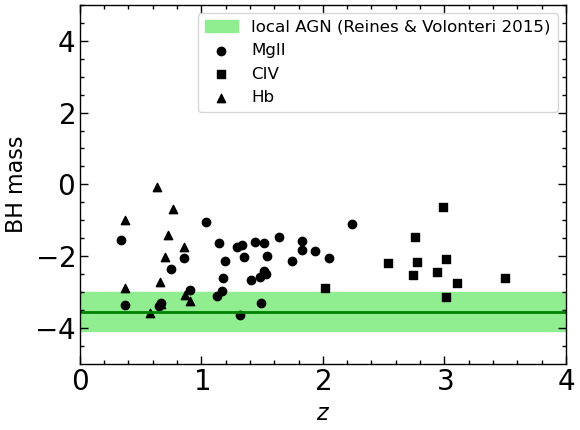

In [231]:
# TODO: Line SNR > 2

fig, ax = plt.subplots(1,1, figsize=(6, 4.5))

# 7.45 - 11
x = np.logspace(8, 13)
ax.plot([0,4],[-3.55,-3.55], color='g')
sigma = 0.55 # sigma in BH mass
ax.fill_between([0, 4], [-3.55-sigma], [-3.55+sigma], color='lightgreen', label='local AGN (Reines & Volonteri 2015)')


ax.scatter(data_join['z'][mask_chi2], #np.log10(1 + data_join['z'][mask_chi2]),
           np.log10((10**data_join['M_MgII_line'][mask_chi2]/10**data_join['logMs'][mask_chi2])),
           label='MgII', marker='o', color='k')
ax.scatter(data_join['z'][mask_chi2], #np.log10(1 + data_join['z'][mask_chi2]),
           np.log10((10**data_join['M_CIV_line'][mask_chi2]/10**data_join['logMs'][mask_chi2])),
           label='CIV', marker='s', color='k')
ax.scatter(data_join['z'][mask_chi2], #np.log10(1 + data_join['z'][mask_chi2]),
           np.log10((10**data_join['M_Hb_line'][mask_chi2]/10**data_join['logMs'][mask_chi2])),
           label='Hb', marker='^', color='k')


ax.legend(frameon=True, fontsize=12)
ax.set_xlim(0.0, 4.0)
ax.set_ylim(-5, 5)

ax.set_xlabel(r'$z$')
ax.set_ylabel('BH mass')

fig.tight_layout()


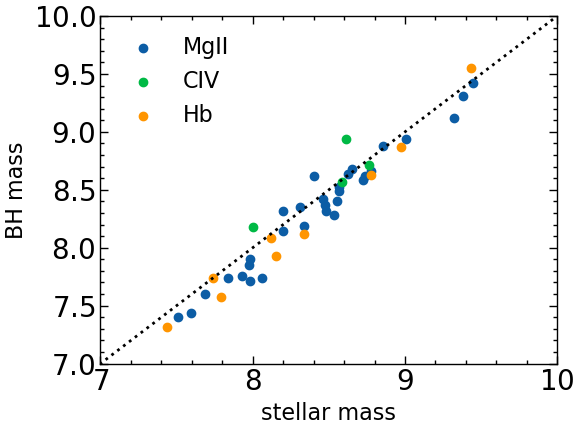

In [219]:
# TODO: Line SNR > 2

fig, ax = plt.subplots(1,1, figsize=(6, 4.5))

#
x = np.logspace(5, 13)
ax.plot(np.log10(x), np.log10(x/1) , linestyle='dotted', color='k')

ax.scatter(data_join['M_MgII'][mask_chi2], data_join['M_MgII_line'][mask_chi2], label='MgII')
ax.scatter(data_join['M_CIV'][mask_chi2], data_join['M_CIV_line'][mask_chi2], label='CIV')
ax.scatter(data_join['M_Hb'][mask_chi2], data_join['M_Hb_line'][mask_chi2], label='Hb')
ax.legend()
ax.set_xlim(7, 10)
ax.set_ylim(7, 10)

ax.set_xlabel('stellar mass')
ax.set_ylabel('BH mass')

fig.tight_layout()
